### **LoRA con PyTorch**

LoRA (Low-Rank Adaptation) es una técnica de **afinado de parámetros eficientes** para grandes modelos de lenguaje (LLM) que permite adaptar un modelo preentrenado a una nueva tarea sin necesidad de actualizar o almacenar todos sus billones de parámetros. A continuación se detalla algunas características importantes:


`Eficiencia en las actualizaciones de parámetros:` LoRA introduce solo una pequeña fracción de parámetros adicionales comparado con el número total de parámetros de un modelo grande. Esto hace que el proceso de entrenamiento sea más rápido y menos intensivo en recursos, ya que se necesitan actualizar menos parámetros durante la retropropagación.

`Preservación del conocimiento preentrenado:` Al mantener la mayoría de los pesos del modelo fijos y ajustarlos únicamente mediante matrices de baja dimensión, LoRA ayuda a conservar las ricas representaciones que el modelo aprendió durante el preentrenamiento. Esto es especialmente beneficioso para tareas que no requieren desviaciones drásticas del comportamiento aprendido en el preentrenamiento.

`Personalización para tareas específicas:` A pesar de las actualizaciones mínimas, los cambios introducidos por LoRA son lo suficientemente significativos como para adaptar el modelo a tareas concretas. Esto permite afinar modelos grandes en tareas especializadas sin necesidad de un reentrenamiento extenso.

`Reducción del sobreajuste:` Debido a que solo se adaptan un número limitado de parámetros, el riesgo de sobreajuste es menor en comparación con el ajuste fino completo del modelo, especialmente al adaptar el modelo a conjuntos de datos más pequeños.

`Escalabilidad:` LoRA escala bien con el tamaño del modelo. A medida que los modelos se vuelven más grandes, el incremento relativo en el número de parámetros introducidos por LoRA se hace aún más pequeño, lo que lo convierte en una opción especialmente atractiva para adaptar modelos muy grandes.

`Compatibilidad y simplicidad:` El método puede aplicarse fácilmente a diferentes tipos de redes neuronales, especialmente a aquellas basadas en la arquitectura Transformer. No requiere cambios importantes en la arquitectura existente, lo que simplifica su integración en pipelines ya establecidos.



#### **Adaptación de baja dimensión (LoRA)**

PyTorch y la librería Hugging Face ofrecen herramientas sólidas para la manipulación de modelos con LoRA, pero no son muy intuitivas. 

En esta sección, profundizaremos en la construcción de una implementación de LoRA (Low-Rank Adaptation) desde cero usando PyTorch. LoRA es un método general, pero se aplica comúnmente a la capa de atención. Por simplicidad, en este cuaderno lo aplicaremos a una red neuronal. Esta decisión se toma porque acceder a los parámetros de *atención* en el módulo Encoder de PyTorch puede resultar complejo.

#### **LoRA**

1. Para cualquier capa arbitraria de una red, tienes el modelo con parámetros preentrenados $W_0$, que son los parámetros del modelo. Si solo consideras los parámetros de atención de cada capa, al menos $4 \times m \times n$ por capa. En muchos modelos, esto puede alcanzar billones de parámetros aprendibles. Cada vez que afinamos con un nuevo conjunto de datos, tendrías que almacenar billones de parámetros.

2. $\Delta W$ representa dos matrices $B$ y $A$, donde $B$ y $A$ están constriñidas de manera que $B \in \mathbb{R}^{m \times r}$, $A \in \mathbb{R}^{r \times n}$, y $r \le \min(m,n)$. El número total de parámetros en $A$ y $B$ es mucho menor que en $W_1$ y mucho más fácil de almacenar.

$$
W_1 \approx W_0 + \Delta W = W_0 + BA
$$

3. Para entrenar y predecir, en el pase hacia adelante $W_0$ se mantiene constante:

$$
h = W_0 x + BAx
$$

Para escalar $\Delta W$ por $\tfrac{\alpha'}{r}$, donde $\alpha$ es una constante relacionada con $r$, ajustar $\alpha'$ es similar a sintonizar la tasa de aprendizaje si la inicialización está correctamente escalada. Por lo tanto, se fija $\alpha'$ igual al primer $r$ que se prueba y no se sintoniza más; simplemente se usa $\alpha$. Este escalado reduce la necesidad de retocar hiperparámetros. La forma final es:

$$
h = W_0 x + \frac{\alpha'}{r} BAx = W_0 x + \alpha\,BAx
$$

El siguiente ejemplo ilustra el proceso.

$
W_0 + BA = 
\begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14} \\\\\\\\\\\\\\\\\\\\
w_{21} & w_{22} & w_{23} & w_{24} \\\\\\
w_{31} & w_{32} & w_{33} & w_{34} \\\\\\
w_{41} & w_{42} & w_{43} & w_{44} \\\\\\
\end{bmatrix} +
\begin{bmatrix}
a_1 \\\\\\
a_2 \\\\\\
a_3 \\\\\\
a_4 \\\\\\
\end{bmatrix}
\begin{bmatrix}
b_1 & b_2 & b_3 & b_4 \\\\
\end{bmatrix}
$

Esto muestra el producto de las matrices $A$ y $B$, denotado $AB$, que se puede sumar a $W_0$. Sin embargo, la matriz resultante $W_0 + AB$ está limitada según las dimensiones de $A$ y $B$, debido al concepto de rango (rank).

#### **Rango**

El rango de una matriz es el número de dimensiones en las que "viven" sus filas (o columnas). 

Una matriz cuadrada se dice de **rango completo** (full rank) si su rango es igual al número de filas o columnas. Hagamos esta idea más intuitiva con un ejemplo.

In [1]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
import torchtext#; torchtext.disable_torchtext_deprecation_warning()
from torchtext.vocab import build_vocab_from_iterator, GloVe, Vectors

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sympy import Matrix, init_printing,Symbol

from numpy.linalg import qr,eig,inv,matrix_rank,inv, norm
from scipy.linalg import null_space
from sympy import Matrix, init_printing,Symbol
init_printing()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_matrix_and_subspace(F):
    # Asegura de que F tenga 3 filas para poder visualizar en 3D.
    assert F.shape[0] == 3, "La matriz F debe tener 3 filas para visualización en 3D."
    
    # Crea una figura y un eje 3D
    ax = plt.figure().add_subplot(projection='3d')
    
    # Para cada columna de F, dibujar un vector desde el origen
    for i in range(F.shape[1]):
        ax.quiver(
            0, 0, 0,                   # origen del vector
            F[0, i], F[1, i], F[2, i], # componentes del vector
            color='blue',
            arrow_length_ratio=0.1,
            label=f'Columna {i+1}'     # etiqueta para la leyenda
        )

    # Si F tiene exactamente 2 columnas, dibujar el plano que ellas generan
    if F.shape[1] == 2:
        # Calcula el vector normal al plano generado por las dos columnas
        normal_vector = np.cross(F[:, 0], F[:, 1])
        
        # Crea una malla de puntos en XY para dibujar la superficie del plano
        xx, yy = np.meshgrid(
            np.linspace(-3, 3, 10),
            np.linspace(-3, 3, 10)
        )
        # Ecuación del plano: normal · [x, y, z] = 0  =>  z = ...
        if normal_vector[2] != 0:
            zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2]
        else:
            zz = np.zeros_like(xx)
        
        # Dibuja la superficie del plano con transparencia
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Plano generado')

    # Configura límites de los ejes
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    
    # Etiquetas de los ejes
    ax.set_xlabel('$x_{1}$')
    ax.set_ylabel('$x_{2}$')
    ax.set_zlabel('$x_{3}$')
    
    # Muestra la figura
    plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_matrix_and_subspace(F):
    # Asegura de que F tenga 3 filas para poder visualizar en 3D.
    assert F.shape[0] == 3, "La matriz F debe tener 3 filas para visualización en 3D."
    
    # Crea una figura y un eje 3D
    ax = plt.figure().add_subplot(projection='3d')
    
    # Para cada columna de F, dibujar un vector desde el origen
    for i in range(F.shape[1]):
        ax.quiver(
            0, 0, 0,                   # origen del vector
            F[0, i], F[1, i], F[2, i], # componentes del vector
            color='blue',
            arrow_length_ratio=0.1,
            label=f'Columna {i+1}'     # etiqueta para la leyenda
        )

    # Si F tiene exactamente 2 columnas, dibujar el plano que ellas generan
    if F.shape[1] == 2:
        # Calcula el vector normal al plano generado por las dos columnas
        normal_vector = np.cross(F[:, 0], F[:, 1])
        
        # Crea una malla de puntos en XY para dibujar la superficie del plano
        xx, yy = np.meshgrid(
            np.linspace(-3, 3, 10),
            np.linspace(-3, 3, 10)
        )
        # Ecuación del plano: normal · [x, y, z] = 0  =>  z = ...
        if normal_vector[2] != 0:
            zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2]
        else:
            zz = np.zeros_like(xx)
        
        # Dibuja la superficie del plano con transparencia
        ax.plot_surface(xx, yy, zz, alpha=0.5, color='green', label='Plano generado')

    # Configura límites de los ejes
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    
    # Etiquetas de los ejes
    ax.set_xlabel('$x_{1}$')
    ax.set_ylabel('$x_{2}$')
    ax.set_zlabel('$x_{3}$')
    
    # Muestra la figura
    plt.show()


En el contexto de Low-Rank Adaptation  (LoRA), donde $B \in \mathbb{R}^{d \times r}$, la matriz $B$:

In [5]:
import torch
B=torch.tensor([[1,0],[0,1],[0,0]]).numpy()

Matrix(B)

⎡1  0⎤
⎢    ⎥
⎢0  1⎥
⎢    ⎥
⎣0  0⎦

Esta matriz de $3 \times 2$ tiene columnas que generan un subespacio bidimensional en $\mathbb{R}^3$. Específicamente, las columnas de $B$ son:

- $\mathbf{b}_1 = \begin{bmatrix} 1 \\\\\\\\\\\\\\\\\\ 0 \\ 0 \end{bmatrix}$
- $\mathbf{b}_2 = \begin{bmatrix} 0 \\\\ 1 \\ 0 \end{bmatrix}$

Estos vectores columna son los vectores de la base estándar para el plano $xy$ en $\mathbb{R}^3$ y, por lo tanto, generan el plano $xy$ mostrado en verde en la imagen siguiente. Multiplicar cualquiera de estos vectores columna (en azul) por un escalar siempre resulta en un punto que queda en ese mismo plano.

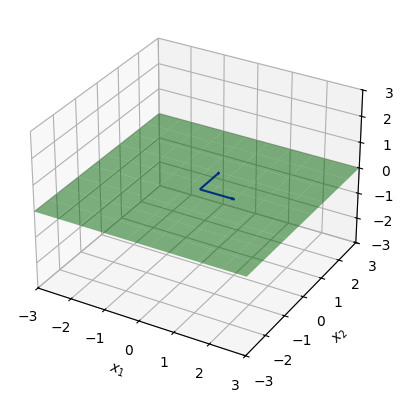

In [6]:
 plot_matrix_and_subspace(B)

En este escenario, los vectores, a pesar de tener cada uno tres componentes, pueden alcanzar cualquier punto del plano verde bidimensional representado en la imagen. Estos vectores abarcan el plano verde, que reside dentro de un subespacio bidimensional. 

La dimensión de este subespacio, también conocida como su "rango", es dos, lo que corresponde a la dimensionalidad del plano. Si el rango fuera tres, cualquier punto en el espacio 3D podría alcanzarse mediante alguna combinación de las columnas de \$𝐵\$. El rango de una matriz se puede determinar usando la función `matrix_rank` proporcionada por NumPy.

In [7]:
matrix_rank(B)

2

Aquí, trazas una matriz diferente donde la matriz abarca un plano distinto, pero el rango sigue siendo dos.

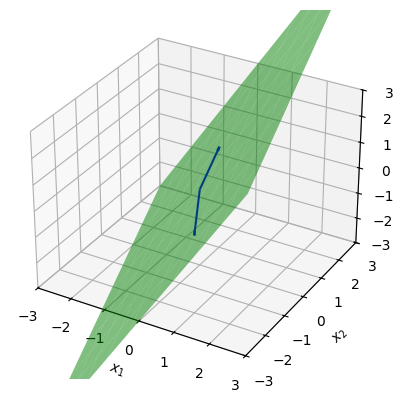

rank de B 2


In [8]:
B_=torch.tensor([[1,0],[-2,1],[0,1]]).numpy()
plot_matrix_and_subspace(B_)
print("rank de B",matrix_rank(B_))

In [9]:
matrix_rank(B)

2

Aquí presentamos la matriz `A`. El rango de esta matriz también es dos.

In [10]:
A=torch.tensor([[1,1,-1,1,0],[-2,2,2,0,1]]).numpy()
Matrix(A)

⎡1   1  -1  1  0⎤
⎢               ⎥
⎣-2  2  2   0  1⎦

In [11]:
matrix_rank(A)

2


Para las matrices $C = BA$, si $B$ y $A$ tienen ambas rango $r$:

In [12]:
C=B@A
Matrix(C)


⎡1   1  -1  1  0⎤
⎢               ⎥
⎢-2  2  2   0  1⎥
⎢               ⎥
⎣0   0  0   0  0⎦

Las columnas de $C$ tendrán el mismo rango que $B$. Además, el espacio generado por las columnas de $C$ será el mismo que el generado por las columnas de $B$.

rank de C 2


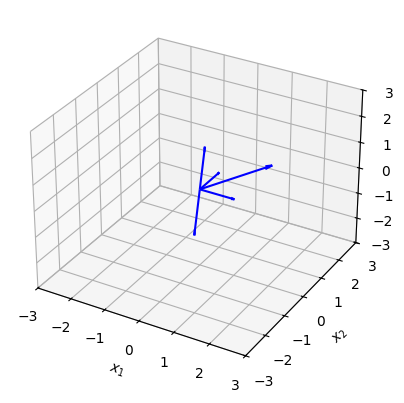

In [13]:
print("rank de C",matrix_rank(C))
plot_matrix_and_subspace(C)

### **Entendiendo LoRA in PyTorch**

LoRA (Low-Rank Adaptation) es relativamente sencillo de inicializar en PyTorch. Se inicializa LoRA con las dimensiones de la entrada (`in_dim`), $m$, la salida (`out_dim`), $n$, un rango (`rank`), $r$, y un factor de escala `alpha`. Los parámetros se inicializan de la siguiente forma:

```
self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
```

El uso de `nn.Parameter` hace que estos valores sean parámetros aprendibles.

En la función forward, LoRA usa la notación $BAx$. En PyTorch, el vector de entrada es una fila, por lo que la salida se convierte en $x^TA^TB^T$; a partir de ahora omitiremos la transposición. El paso forward se implementa como:

```
x = self.alpha * (x @ self.A @ self.B)
```

El uso de `nn.Parameter` hace que estos valores sean parámetros aprendibles.


In [14]:
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = torch.nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

Esta clase `LinearWithLoRA` copia el modelo lineal original y crea un objeto `LoRALayer`.

```
self.linear = linear.to(device)
self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)
```

Luego, en el método forward aplica tanto el modelo lineal original como el modelo LoRA a la entrada `x` y los suma: `self.linear(x) + self.lora(x)`. Esto corresponde a:

$x W_0 + x A B$

In [15]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        ).to(device)

    def forward(self, x):
        
        return self.linear(x) + self.lora(x)

### **Configuración adicionales**

#### Importar las librerías requeridas

El siguiente bloque importa todas las librerías necesarias:


In [16]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import math

import torch
torch.set_num_threads(1)
from torch import nn
import os


from torch.utils.data import DataLoader

from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, Vectors
from torchtext.datasets import IMDB
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pickle

from urllib.request import urlopen
import io

import tarfile
import tempfile

from torch.nn.utils.rnn import pad_sequence

# También puedes usar esta sección para suprimir las advertencias generadas por tu código:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

#### **Funciones auxiliares**

El siguiente código muestra algunas funciones de ayuda para graficar, guardar y cargar archivos. Estas funciones no son el foco principal del cuaderno, pero debes ejecutar estas celdas para poder usarlas más adelante.


In [17]:
def plot(COST,ACC):
    """
    Grafica la evolución de la pérdida total y la precisión por época.

    Parámetros:
        COST (list): Lista con el valor de la pérdida total en cada época.
        ACC (list): Lista con la precisión en cada época.
    """

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoca', color=color)
    ax1.set_ylabel('Perdida total', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout() 

    plt.show()

In [18]:
def save_list_to_file(lst, filename):
    """
    Guarda una lista en un archivo usando serialización con pickle.

    Parámetros:
        lst (list): La lista que se guardará.
        filename (str): El nombre del archivo donde se guardará la lista.

    Retorna:
        None
    """
    with open(filename, 'wb') as file:
        pickle.dump(lst, file)

def load_list_from_file(filename):
    """
    Carga una lista desde un archivo usando deserialización con pickle.

    Parámetros:
        filename (str): El nombre del archivo desde el cual se cargará la lista.

    Retorna:
        list: La lista cargada.
    """
    with open(filename, 'rb') as file:
        loaded_list = pickle.load(file)
    return loaded_list

#### **Pipeline de datos**

**Tokenizador**

In [19]:
from torchtext.data.utils import get_tokenizer

In [20]:
tokenizer = get_tokenizer("basic_english")

In [21]:
def yield_tokens(data_iter):
    for  _,text in data_iter:
        yield tokenizer(text)

In [22]:
# Nota: los embeddings de GloVe normalmente se descargan usando:
# glove_embedding = GloVe(name="6B", dim=100)
# Sin embargo, el servidor de GloVe frecuentemente está inactivo.
# El código siguiente ofrece una solución alternativa.

class GloVe_override(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        name = "glove.{}.{}d.txt".format(name, str(dim))
        #name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override, self).__init__(name, url=url, **kwargs)

class GloVe_override2(Vectors):
    url = {
        "6B": "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tQdezXocAJMBMPfUJx_iUg/glove-6B.zip",
    }

    def __init__(self, name="6B", dim=100, **kwargs) -> None:
        url = self.url[name]
        #name = "glove.{}.{}d.txt".format(name, str(dim))
        name = "glove.{}/glove.{}.{}d.txt".format(name, name, str(dim))
        super(GloVe_override2, self).__init__(name, url=url, **kwargs)

try:
    glove_embedding = GloVe_override(name="6B", dim=100)
except:
    try:
        glove_embedding = GloVe_override2(name="6B", dim=100)
    except:
        glove_embedding = GloVe(name="6B", dim=100)

#### **Importamos el conjunto de datos IMDB**

El siguiente código carga y manejo del conjunto de datos IMDB. 


In [23]:
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/35t-FeC-2uN1ozOwPs7wFg.gz')
tar = tarfile.open(fileobj=io.BytesIO(urlopened.read()))
tempdir = tempfile.TemporaryDirectory()
tar.extractall(tempdir.name)
tar.close()

In [24]:
class IMDBDataset(Dataset):
    def __init__(self, root_dir, train=True):
        """
        root_dir: El directorio base del conjunto de datos IMDB.
        train: Indicado booleano que indica si se debe usar datos de entrenamiento o de prueba.
        """
        self.root_dir = os.path.join(root_dir, "train" if train else "test")
        self.neg_files = [os.path.join(self.root_dir, "neg", f) for f in os.listdir(os.path.join(self.root_dir, "neg")) if f.endswith('.txt')]
        self.pos_files = [os.path.join(self.root_dir, "pos", f) for f in os.listdir(os.path.join(self.root_dir, "pos")) if f.endswith('.txt')]
        self.files = self.neg_files + self.pos_files
        self.labels = [0] * len(self.neg_files) + [1] * len(self.pos_files)
        self.pos_inx=len(self.pos_files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        return label, content

El siguiente código utiliza la clase `IMDBDataset` definida anteriormente para crear iteradores de los conjuntos de datos de entrenamiento y prueba. Luego, muestra 20 ejemplos del conjunto de entrenamiento:


In [25]:
root_dir = tempdir.name + '/' + 'imdb_dataset'
train_iter = IMDBDataset(root_dir=root_dir, train=True)  # Para datos de entrenamiento
test_iter = IMDBDataset(root_dir=root_dir, train=False)  # Para datos de prueba

start=train_iter.pos_inx
for i in range(-10,10):
    print(train_iter[start+i])

(0, "**SPOILERS**This was an ugly movie, and I'm sorry that I watched it. Like Jan Kounen's Dobermann, it suffers mostly from poor editing--or lack of it. It is as if the director was so in love with his work that instead of cutting the movie down to a pace that kept your attention, he added all of the footage he had shot together. There are maybe two cool scenes in the entire movie. One of them is *SPOILER* when Benkei is petrified and the camera starts spinning around him. That was cool--but okay, we got it! Move on please! The camera won't stop spinning around this guy! There's maybe one or two more cool scenes that I forgot about in this flood of mediocrity, but the last duel scene IS NOT ONE OF THEM! It may be because unlike in the earlier sword-handling scenes, Shanao isn't masked--but just because the director couldn't find a stuntman who somewhat resembled Asano Tadanobu doesn't give him the right to go ahead and make up 80% of the sword fight with extreme close-ups of sword cl

El siguiente fragmento define el mapeo de etiquetas numéricas a reseñas negativas y positivas:


In [26]:
imdb_label = {0: " negative review", 1: "positive review"}
imdb_label[1]

'positive review'

Por último, este código verifica que en el conjunto de entrenamiento existan exactamente dos clases:


In [27]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

El siguiente código carga un tokenizador básico en inglés y define una función llamada `yield_tokens` que utiliza el tokenizador para descomponer datos de texto proporcionados por un iterador en tokens:


In [28]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    """Devuelve tokens para cada muestra de datos."""
    for _, text in data_iter:
        yield tokenizer(text)

El siguiente código carga un modelo de embeddings de palabras preentrenado llamado GloVe en una variable llamada `glove_embedding`:


El siguiente código construye un objeto vocabulario a partir de un modelo de incrustaciones de palabras GloVe preentrenado y establece el índice predeterminado en el token `<unk>`:


In [29]:
from torchtext.vocab import GloVe,vocab
# Construye el vocabulario a partir de glove_embedding.stoi
vocab = vocab(glove_embedding .stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

Contemos el número de palabras en el vocabulario:


In [30]:
vocab_size=len(vocab)
vocab_size

Probemos la función `vocab`:


In [31]:
vocab(["age","hello"])


#### **División del conjunto de datos**



In [32]:
# Convierte los iteradores de entrenamiento y prueba en conjuntos de datos de estilo map.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determina el número de muestras para entrenamiento y validación (5 % para validación).
num_train = int(len(train_dataset) * 0.95)

# Divide aleatoriamente el conjunto de entrenamiento en entrenamiento y validación.
# El conjunto de entrenamiento tendrá el 95 % de las muestras y el de validación el 5 % restante.
split_train_, split_valid_ = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train]
)



Para simular el proceso como si se tuviera GPU, reducimos aún más el tamaño del conjunto de entrenamiento. Si deseas usar el conjunto IMDB completo, comenta o elimina las dos líneas siguientes:


In [33]:
num_train = int(len(train_dataset) * 0.05)
split_train_, _ = random_split(split_train_, [num_train, len(split_train_) - num_train])

El siguiente código verifica si hay una GPU compatible con CUDA disponible usando PyTorch. Si existe, asigna `device = "cuda"`, de lo contrario `device = "cpu"`:

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### **Cargador de datos**

El siguiente código prepara el pipeline de procesamiento de texto con el tokenizador y el vocabulario. 

La función `text_pipeline` primero tokeniza el texto de entrada y luego aplica `vocab` para obtener los índices de los tokens:

In [35]:
def text_pipeline(x):
    return vocab(tokenizer(x))

En PyTorch, la función **`collate_fn`** se utiliza junto con los data loaders para personalizar la forma en que se crean los lotes a partir de muestras individuales. El código proporcionado define una función `collate_batch` en PyTorch, que se emplea con los data loaders para ajustar la creación de lotes a partir de muestras individuales. Esta función procesa un lote de datos, incluyendo etiquetas y secuencias de texto. 

Aplica la función `text_pipeline` para preprocesar el texto. Los datos resultantes se convierten en tensores de PyTorch y se devuelven como una tupla que contiene el tensor de etiquetas, el tensor de texto y un tensor de offsets que representa las posiciones iniciales de cada secuencia de texto dentro del tensor combinado.

Además, la función se asegura de que los tensores generados se muevan al dispositivo especificado (por ejemplo, GPU) para un cálculo más eficiente.


In [36]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:

        label_list.append(_label)
        text_list.append(torch.tensor(text_pipeline(_text), dtype=torch.int64))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = pad_sequence(text_list, batch_first=True)

    return label_list.to(device), text_list.to(device)

Puedes convertir estos conjuntos de datos en data loaders aplicando `collate_fn`:

In [37]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)


Comprobemos qué generan estos data loaders:


In [38]:
label,seqence=next(iter(valid_dataloader))
label,seqence

(tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 0, 1, 0]),
 tensor([[   43,  3138,     2,  ...,     0,     0,     0],
         [   43,    96,    93,  ...,     0,     0,     0],
         [   25,    93,  2094,  ...,     0,     0,     0],
         ...,
         [   39,   321,    88,  ...,     0,     0,     0],
         [ 2058,    31, 20722,  ...,     0,     0,     0],
         [  104,     9,   355,  ...,     0,     0,     0]]))

#### **Red neuronal**

Este código define una clase llamada `TextClassifier` que representa un clasificador de texto sencillo que utiliza:

* una capa de embedding,
* una capa lineal oculta con activación ReLU,
* y una capa lineal de salida.

El constructor recibe los siguientes argumentos:

* `num_class`: el número de clases a clasificar.
* `freeze`: indica si se debe congelar la capa de embedding.

In [39]:
from torch import nn
import torch

class TextClassifier(nn.Module):
    def __init__(self, num_classes, freeze=False):
        super(TextClassifier, self).__init__()
        # Capa de embedding precargada con vectores GloVe; opcionalmente congelada
        self.embedding = nn.Embedding.from_pretrained(
            glove_embedding.vectors.to(device),
            freeze=freeze
        )
        # Ejemplo de capa adicional: capa lineal intermedia
        self.fc1 = nn.Linear(in_features=100, out_features=128)
        # Activación ReLU tras la capa lineal
        self.relu = nn.ReLU()
        # Capa de salida que produce las puntuaciones (logits) para cada clase
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        # Pasa la secuencia de índices por la capa de embedding
        x = self.embedding(x)
        # Aplica un pooling por media sobre la dimensión de secuencia
        x = torch.mean(x, dim=1)
        # Pasa los embeddings agrupados por la capa lineal intermedia…
        x = self.fc1(x)
        # …y aplica la activación ReLU
        x = self.relu(x)
        # Devuelve los logits finales para cada clase
        return self.fc2(x)


#### **Entrenamiento del modelo sobre todo el conjunto**

In [40]:
modelo=TextClassifier(num_classes=2,freeze=True)
modelo.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [41]:
modelo.eval()
predicted_label=modelo(seqence)

In [42]:
print(predicted_label.shape)

torch.Size([32, 2])


In [43]:
predicted_label

tensor([[-0.1529, -0.0431],
        [-0.1569, -0.0378],
        [-0.1086, -0.0911],
        [-0.1561, -0.0367],
        [-0.1114, -0.0798],
        [-0.1391, -0.0590],
        [-0.1025, -0.0955],
        [-0.0974, -0.0900],
        [-0.1415, -0.0500],
        [-0.1494, -0.0482],
        [-0.1537, -0.0420],
        [-0.1438, -0.0524],
        [-0.1520, -0.0427],
        [-0.1478, -0.0516],
        [-0.1465, -0.0465],
        [-0.1526, -0.0426],
        [-0.1539, -0.0403],
        [-0.1503, -0.0546],
        [-0.1394, -0.0592],
        [-0.1458, -0.0538],
        [-0.1537, -0.0439],
        [-0.1539, -0.0401],
        [-0.1214, -0.0799],
        [-0.1510, -0.0454],
        [-0.1492, -0.0481],
        [-0.1318, -0.0565],
        [-0.1515, -0.0459],
        [-0.1470, -0.0502],
        [-0.1412, -0.0647],
        [-0.1337, -0.0616],
        [-0.1570, -0.0372],
        [-0.1263, -0.0757]], grad_fn=<AddmmBackward0>)

La siguiente función **`predict`** toma como entradas un texto, una secuencia de texto y un modelo. Utiliza un modelo preentrenado que se pasa como parámetro para predecir la etiqueta del texto para su clasificación en el conjunto de datos IMDB:


In [44]:
def predict(text, text_pipeline, modelo):
    with torch.no_grad():
        text = torch.unsqueeze(torch.tensor(text_pipeline(text)),0).to(device)
        modelo.to(device)
        output = modelo(text)
        return imdb_label[output.argmax(1).item()]

In [45]:
predict("I like sports and stuff", text_pipeline, modelo)

'positive review'


Podemos crear una función para evaluar la exactitud del modelo en un conjunto de datos:


In [46]:
def evaluate(dataloader, modelo, device):
    modelo.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for label, text in dataloader:
            label, text = label.to(device), text.to(device)
            outputs = modelo(text)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    accuracy = 100 * correct / total
    return accuracy

El siguiente código evalúa el rendimiento del modelo (puede tardar unos 4 minutos en CPU). **Para mayor eficiencia, no ejecutaremos esta celda ahora**, pero puede descomentarse si se desea comprobar que el modelo sin entrenar no rinde mejor que el azar:



In [47]:
#evaluate(test_dataloader, modelo, device)

Ten en cuenta que el rendimiento actual del modelo no es mejor que el promedio. Este resultado es esperado, considerando que el modelo aún no ha recibido ningún entrenamiento.



### **Entrenamiento**


El siguiente código define la función de entrenamiento que se utiliza para entrenar tu modelo.



In [48]:
def train_model(modelo, optimizer, criterion, train_dataloader, valid_dataloader, epochs=100, model_name="mi_modeldrop"):
    cum_loss_list = []
    acc_epoch = []
    best_acc = 0
    file_name = model_name
    
    for epoch in tqdm(range(1, epochs + 1)):
        modelo.train()
        cum_loss = 0
        for _, (label, text) in enumerate(train_dataloader):            
            optimizer.zero_grad()
            predicted_label = modelo(text)
            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(modelo.parameters(), 0.1)
            optimizer.step()
            cum_loss += loss.item()
        #print("Funcion de perdida:", cum_loss)
        cum_loss_list.append(cum_loss)
        acc_val = evaluate(valid_dataloader, modelo, device)
        acc_epoch.append(acc_val)
        
        if acc_val > best_acc:
            best_acc = acc_val
            print(f"Nueva mejor exactituf: {acc_val:.4f}")
            #torch.save(modelo.state_dict(), f"{model_name}.pth")
    
    #save_list_to_file(cum_loss_list, f"{model_name}_loss.pkl")
    #save_list_to_file(acc_epoch, f"{model_name}_acc.pkl")



El siguiente código establece la tasa de aprendizaje (LR) en 1, que determina el tamaño del paso con el que el optimizador actualiza los parámetros del modelo durante el entrenamiento. El criterio `CrossEntropyLoss` se utiliza para calcular la pérdida entre las salidas predichas por el modelo y las etiquetas reales. Esta función de pérdida se emplea comúnmente en tareas de clasificación multiclase.

El optimizador elegido es Stochastic Gradient Descent (SGD), que ajusta los parámetros del modelo en función de los gradientes calculados respecto a la función de pérdida. El optimizador SGD utiliza la tasa de aprendizaje especificada para controlar el tamaño de las actualizaciones de los pesos.

Además, se define un programador de tasa de aprendizaje mediante `StepLR`. Este programador ajusta la tasa de aprendizaje durante el entrenamiento, reduciéndola en un factor (`gamma`) de 0.1 después de cada época (paso) para mejorar la convergencia y afinar el rendimiento del modelo. Estos componentes forman, en conjunto, la configuración esencial para entrenar una red neuronal usando la tasa de aprendizaje, el criterio de pérdida, el optimizador y el programador de tasa de aprendizaje especificados.


In [49]:
LR=1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelo.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

Se a preentrenado el modelo para 300 épocas con una GPU y se ha guardado para tu comodidad. Sin embargo, para ilustrar el proceso de entrenamiento, se ha incluido el siguiente código que entrena el modelo solo para dos épocas. Ten en cuenta que ha limitado el número de épocas a dos, ya que el entrenamiento en una CPU puede llevar mucho tiempo. Incluso con solo dos épocas, el siguiente código puede tardar aproximadamente un minuto en ejecutarse.

In [50]:
model_name="model_imdb_freeze_true2"
train_model(modelo, optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)

 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 1/2 [00:00<00:00,  1.72it/s]

Nueva mejor exactituf: 48.7200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]


En lugar de evaluar el modelo entrenado en 2 épocas, carguemos el modelo preentrenado que fue entrenado durante 300 épocas:


In [51]:
%%capture 
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/ZvhVWJU0flC7BmU1jjYxjg/model-imdb-freeze-true2.pth
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/2RdN-JG4Rm5Gx3UNtOP4NA/model-imdb-freeze-true2-acc.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8qoGvWk0BdXRGoFAOT-dAw/model-imdb-freeze-true2-loss.pkl


Grafiquemos el costo y la exactitud de cada época para el modelo preentrenado, que se entrenó para 300 épocas. El gráfico muestra que, con solo unas pocas épocas, la exactitud presenta una volatilidad significativa.

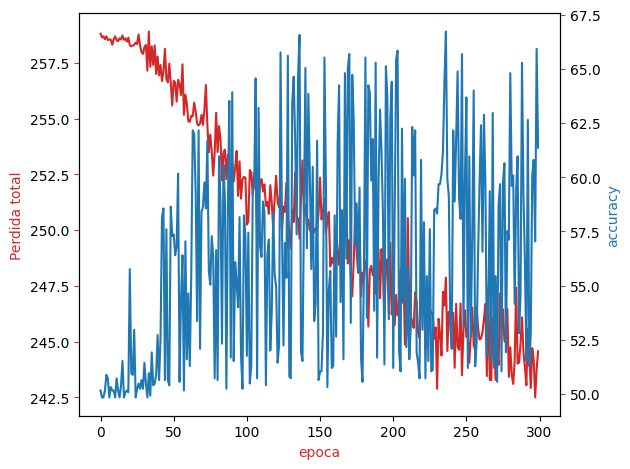

In [52]:
cum_loss_list=load_list_from_file(model_name.replace('_','-') + "-loss.pkl")
acc_epoch=load_list_from_file(model_name.replace('_','-') + "-acc.pkl")
plot(cum_loss_list,acc_epoch)

Cargamos el modelo que se ha entrenado. Si deseas entrenar el modelo tu mismo comente estas líneas.


In [53]:
modelo.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
modelo.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

A continuación, se evalúa el modelo con los datos de prueba. El modelo preentrenado alcanza una exactitud del 66 %.

In [54]:
evaluate(test_dataloader , modelo, device)

### **Aplicando LoRA**

Para afinar con LoRA, primero carga un modelo **TextClassifier** preentrenado con LoRA (mientras congelas sus capas), carga su estado preentrenado desde un archivo y luego deshabilita las actualizaciones de gradiente para todos sus parámetros para evitar entrenamiento adicional.

Aquí, cargare,ps un modelo que fue preentrenado en el conjunto de datos AG NEWS, el cual tiene 4 clases. 

Observa que cuando inicializas este modelo, estableces `num_classes` en 4. Además, el modelo AG\_News preentrenado se entrenó con la capa de embedding sin congelar. Por lo tanto, inicializarás el modelo con `freeze=False`. Aunque estés inicializando el modelo con capas sin congelar y con un número incorrecto de clases para tu tarea, harás modificaciones más adelante que corregirán esto:


In [55]:
from urllib.request import urlopen
import io

model_lora=TextClassifier(num_classes=4,freeze=False)
model_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_lora.load_state_dict(state_dict)

# Aquí, congelas todas las capas:
for parm in model_lora.parameters():
    parm.requires_grad=False
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Ten en cuenta que el bucle `for` en el código anterior congeló todas las capas de la red neuronal, incluyendo la capa de embedding.

Además, observa que el modelo original resolvía un problema de clasificación con cuatro clases, mientras que el conjunto de datos IMDB solo tiene 2 clases. Para tener esto en cuenta, reemplazamos la capa final por una nueva capa lineal donde el número de salidas sea igual a 2:


In [56]:
model_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Veamos todos los módulos en el objeto:


In [57]:
model_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Tu tarea ahora es reemplazar la capa oculta por una capa LoRA. Puedes acceder a la capa oculta de la siguiente forma:

In [58]:
model_lora.fc1

Linear(in_features=100, out_features=128, bias=True)

Lo siguiente reemplaza esta capa por una capa LoRA:

In [59]:
model_lora.fc1=LinearWithLoRA(model_lora.fc1,rank=2, alpha=0.1).to(device)

Veamos nuevamente la capa oculta para asegurarnos de que efectivamente se haya convertido en una capa LoRA.


In [60]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

En este punto, entrenar el modelo es similar, con la única diferencia de que, salvo la capa de salida, solo los parámetros aprendibles
`A` y `B` se actualizarán. El código para seleccionar los valores de `r` y `alpha`, que no se ejecuta, se proporciona aquí para tu conveniencia:

In [61]:
model_lora.to(device)

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

<details> 
<summary><b>Haz clic aquí para ver el código para seleccionar r y alpha</b></summary>

```python 
ranks = [1, 2, 5, 10]
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]

results = []
accuracy_old = 0
# Itera sobre cada combinación de 'r' y 'alpha'
for r in ranks:
    for alpha in alphas:
        print(f"Pruebas con rank = {r} and alpha = {alpha}")
        model_name = f"model_lora_rank{r}_alpha{alpha}_AGtoIBDM_final_adam_"
        
        model_lora = TextClassifier(num_classes=4, freeze=False)
        model_lora.to(device)
        
        urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')
        
        stream = io.BytesIO(urlopened.read())
        state_dict = torch.load(stream, map_location=device)
        model_lora.load_state_dict(state_dict)
        
        for parm in model_lora.parameters():
            parm.requires_grad = False
        
        model_lora.fc2 = nn.Linear(in_features=128, out_features=2, bias=True)
        model_lora.fc1 = LinearWithLoRA(model_lora.fc1, rank=r, alpha=alpha)
        optimizer = torch.optim.Adam(model_lora.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        
        model_lora.to(device)
        
        train_model(model_lora, optimizer, criterion, train_dataloader, valid_dataloader, epochs=300, model_name=model_name)
        
        accuracy = evaluate(valid_dataloader, model_lora, device)
        result = {
            'rank': r,
            'alpha': alpha,
            'accuracy': accuracy
        }

        # Agrega el diccionario a la lista de resultados
        results.append(result)
        
        if accuracy > accuracy_old:
            print(f"Pruebas con rank = {r} and alpha = {alpha}")
            print(f"Exactitud: {accuracy} accuracy_old: {accuracy_old}")
            accuracy_old = accuracy
            torch.save(model.state_dict(), f"{model_name}.pth")
            save_list_to_file(cum_loss_list, f"{model_name}_loss.pkl")
            save_list_to_file(acc_epoch, f"{model_name}_acc.pkl")
```

Ahora, configuremos los componentes de entrenamiento para el modelo `model_lora`, definiendo una tasa de aprendizaje de 1, usando la pérdida de entropía cruzada como criterio, optimizando con descenso de gradiente estocástico (SGD) y programando la tasa de aprendizaje para que decaiga en un factor de 0.1 en cada época:


In [62]:
LR=1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_lora.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)


Se ha preentrenado un modelo usando un procedimiento idéntico durante 300 épocas y lo guardaste para tu conveniencia. Sin embargo, para que veas cómo funciona el entrenamiento en la práctica, ejecuta el siguiente código para entrenar el modelo solo durante 2 épocas:


In [63]:
model_name="model_lora_final2"
train_model(model_lora,optimizer, criterion, train_dataloader, valid_dataloader, epochs=2, model_name=model_name)


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 1/2 [00:00<00:00,  1.41it/s]

Nueva mejor exactituf: 51.2800


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]

Nueva mejor exactituf: 53.4400


En lugar de evaluar el modelo que acabas de entrenar por 2 épocas, veamos el modelo LoRA preentrenado con 300 épocas:

In [64]:
%%capture 
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/JWPRb1RMhKLRMUWOKw9pxA/model-lora-final2.pth
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_dm02rLyTrwsXEQh2r32sQ/model-lora-final2-acc.pkl
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/OZbVqKjoqOSIwnET8AB1KA/model-lora-final2-loss.pkl


Lo siguiente muestra la progresión del entrenamiento de este modelo durante 300 épocas:

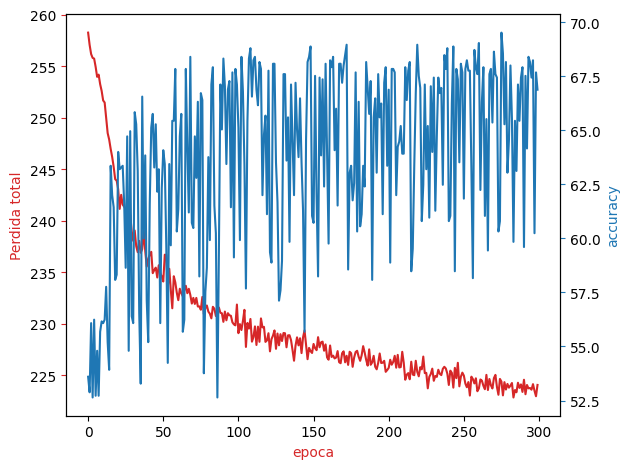

In [65]:
cum_loss_list=load_list_from_file(model_name.replace('_','-') + "-loss.pkl")
acc_epoch=load_list_from_file(model_name.replace('_','-') + "-acc.pkl")
plot(cum_loss_list,acc_epoch)

Ahora, carguemos realmente el modelo en `model_lora`:

In [66]:
model_lora.load_state_dict(torch.load(model_name.replace('_','-') + ".pth", map_location=device))
model_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Y evaluemos su rendimiento en los datos de prueba:

Obtienes una mejora del 3% sobre un modelo entrenado desde cero al usar LoRA. Ten en cuenta que esto ocurre a pesar de que el modelo afinado con LoRA actualizó menos parámetros que el modelo entrenado desde cero.


El atributo `model_lora.fc1` representa `LinearWithLoRA`, que contiene tanto la capa estándar `Linear` (`linear`) como una capa adicional `LoRA` (`lora`), la cual representa `LoRALayer`:

In [67]:
model_lora.fc1

LinearWithLoRA(
  (linear): Linear(in_features=100, out_features=128, bias=True)
  (lora): LoRALayer()
)

Desde `model_lora.fc1.lora` puedes obtener los parámetros aprendibles **A** y **B**:

In [68]:
B=model_lora.fc1.lora.B
print("B",B)
print("\n Numero de elementos en el tensor B",B.numel())
torch.save(B, 'B.pth')

B Parameter containing:
tensor([[-4.3192e-01, -1.1071e+00,  2.4456e-01, -3.1031e-02, -2.0012e-01,
         -6.7811e-01, -1.3552e-01, -2.7458e-01,  3.2278e-02,  6.7592e-02,
          8.3020e-01,  1.1610e-05, -1.0894e-01,  7.7830e-05, -1.6789e-01,
         -1.3309e-01, -5.1875e-01,  2.1928e-02, -6.5869e-02, -3.5834e-01,
         -2.4473e-02, -1.1260e+00, -8.8752e-02, -7.0861e-03, -1.3263e-02,
          0.0000e+00, -6.9039e-01, -8.6471e-02, -3.9146e-01, -2.2644e-01,
         -8.7611e-01, -7.9929e-01,  0.0000e+00,  3.9646e-01,  5.2164e-01,
         -4.2730e-01,  2.3550e-01,  4.0447e-02,  2.3289e-01, -4.5217e-01,
          1.7721e-03, -4.7263e-01, -2.4343e-01,  6.3737e-01,  0.0000e+00,
          2.6904e-03, -7.8828e-01,  2.2559e-02, -4.3776e-02,  3.0909e-01,
         -1.6914e-01, -2.0294e-01, -4.2175e-01,  7.8840e-01, -3.1771e-01,
         -2.0639e-01,  1.1487e-02, -5.7238e-01,  1.4071e-01, -2.8561e-01,
          1.1753e-01, -1.6501e-04, -4.5406e-01,  0.0000e+00,  6.4464e-05,
         -4.45

In [70]:
A=model_lora.fc1.lora.A
print("A",A)
print("\n Numero de elementos en el tensor A",A.numel())
torch.save(A, 'A.pth')

A Parameter containing:
tensor([[ 3.2952e-01,  9.3019e-01],
        [ 2.3904e+00, -5.1022e+00],
        [-2.4573e-01,  2.4733e+00],
        [ 5.8014e-01,  3.9014e-01],
        [ 1.6970e+00, -2.4614e+00],
        [-1.2420e+00,  8.3014e-01],
        [-2.0468e+00,  1.1629e+00],
        [-5.9361e-01,  1.8099e-01],
        [ 9.2466e-02,  1.1583e-01],
        [-2.0841e-02,  1.5550e+00],
        [ 1.3028e+00, -9.8381e-01],
        [ 1.4320e+00, -3.3497e+00],
        [-1.1637e+00,  1.9436e+00],
        [ 2.4898e-01, -1.1353e+00],
        [ 2.4423e+00,  1.0154e+00],
        [ 2.4881e+00, -4.6765e+00],
        [-1.8985e-01,  1.3426e+00],
        [-1.1730e-01, -2.1925e+00],
        [ 2.0193e+00, -8.5886e-01],
        [-3.1268e+00,  3.5134e+00],
        [ 1.0935e+00, -2.9263e+00],
        [-1.0435e+00,  2.5428e-01],
        [-8.6704e-01,  2.3570e+00],
        [-5.2725e-02, -2.3731e-01],
        [-4.3896e+00,  5.0369e+00],
        [-1.1174e+00,  9.9728e-01],
        [ 4.7710e-01, -1.2162e+00],
    

A y B tienen aproximadamente 450 parámetros. Si guardaras la capa lineal completa, tendrías 12,800 parámetros, lo que es alrededor de 28 veces más. 

Recuerda, este es posiblemente el modelo más simple que puedas tener.

In [71]:
print("\n Numero de elementos en el tensor A",model_lora.fc1.linear.weight.numel())


 Numero de elementos en el tensor A 12800


Alfa y la capa de salida también se guardan:

In [72]:
alfa_=model_lora.fc1.lora.alpha
torch.save(alfa_, 'alfa_.pth')
torch.save(model_lora.fc2.state_dict(), 'out_layer.pth')


#### **Cargando el modelo**

La principal ventaja de LoRA es que para el fine-tuning solo necesitas guardar los parámetros entrenables A y B, el factor α, y la capa de salida en tu ejemplo de clasificación.

Los archivos guardados se convierten en tensores y la capa lineal, respectivamente.

In [73]:
A = torch.load('A.pth')
print("A:",A.shape)

A: torch.Size([100, 2])


In [74]:
B = torch.load('B.pth')
print("B:",B.shape)

B: torch.Size([2, 128])


In [75]:
alfa_ = torch.load('alfa_.pth')
alfa_ 

La capa de salida:

In [76]:
output_layer=nn.Linear(in_features=128, out_features=2, bias=True)
output_layer.load_state_dict(torch.load('out_layer.pth'))

<All keys matched successfully>

Se crea el objeto del modelo y se cargan los parámetros preentrenados:


In [77]:
model_load_lora = TextClassifier(num_classes=4,freeze=False)
model_load_lora.to(device)

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/uGC04Pom651hQs1XrZ0NsQ/my-model-freeze-false.pth')

stream = io.BytesIO(urlopened.read())
state_dict = torch.load(stream, map_location=device)
model_load_lora.load_state_dict(state_dict)

model_load_lora

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

Se añade la capa LoRA a la capa oculta original:

In [78]:
model_load_lora.fc1=LinearWithLoRA(model_load_lora.fc1,rank=2, alpha=0.1)
model_load_lora.fc2=nn.Linear(in_features=128, out_features=2, bias=True).to(device)

Se incorporan los parámetros obtenidos del fine-tuning:

In [79]:
model_load_lora.fc1.lora.A=A
model_load_lora.fc1.lora.B=B
model_load_lora.fc1.lora.alpha=alfa_ 
model_load_lora.fc2=output_layer

In [80]:
model_load_lora.to(device)
model_load_lora.eval()

TextClassifier(
  (embedding): Embedding(400000, 100)
  (fc1): LinearWithLoRA(
    (linear): Linear(in_features=100, out_features=128, bias=True)
    (lora): LoRALayer()
  )
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [81]:
evaluate(test_dataloader , model_load_lora, device)

Esto confirma que el modelo se cargó correctamente. Aún obtienes una mejora del 3 % en exactitud!.

Finalmente, se muestra cómo hacer una predicción sobre el siguiente artículo utilizando la función **`predict`**:

In [82]:
article="""This was a lacklustre movie with very little going for it. I was not impressed."""

Este contenido en Markdown genera un recuadro con fondo gris claro y padding. Contiene un encabezado `<h3>` que muestra el contenido de la variable `article` y un `<h4>` que indica la categoría predicha del artículo, proporcionada por la variable `result`. Los marcadores `{article}` y `{result}` se reemplazarán dinámicamente con los valores reales al renderizarse el Markdown.


In [ ]:
result = predict(article, model_load_lora, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)

#### **Ejercicio: Aplicar LoRA a una red distinta para reconocimiento de letras**

Partiendo de la clase `NNet` (diseñada originalmente para dígitos 0–9), tu tarea es:

1. **Reemplazar la última capa** para que la red tenga 26 salidas (una por cada letra del alfabeto inglés).
2. **Congelar todos los parámetros originales** y **aplicar LoRA** únicamente a la segunda capa lineal (`fc2`), usando rango 2 y factor de escala $\alpha=0.1$.
3. 
4. Verificar que sólo los parámetros de las capas LoRA y de la nueva capa de salida estén marcados para entrenamiento (`requires_grad=True`).

**Código base con la sección de LoRA ya integrada**

```python
import torch
import torch.nn as nn
import torch.nn.functional as F

# Asumimos que LinearWithLoRA está definido/importado correctamente:
# from lora import LinearWithLoRA

class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        # Capa de convolución C1: 1 canal de entrada, 6 de salida, kernel 5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Capa de convolución C3: 6 canales de entrada, 16 de salida, kernel 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Capa totalmente conectada F5: de 400 a 120 neuronas
        self.fc1  = nn.Linear(16 * 5 * 5, 120)
        # Capa totalmente conectada F6: de 120 a 84 neuronas
        self.fc2  = nn.Linear(120, 84)
        # Capa de salida original (se reemplazará después)
        self.fc3  = nn.Linear(84, 10)

    def forward(self, x):
        # C1 + ReLU -> tamaño (N, 6, 28, 28)
        x = F.relu(self.conv1(x))
        # S2 Pooling 2x2 -> tamaño (N, 6, 14, 14)
        x = F.max_pool2d(x, 2)
        # C3 + ReLU -> tamaño (N, 16, 10, 10)
        x = F.relu(self.conv2(x))
        # S4 Pooling 2x2 -> tamaño (N, 16, 5, 5)
        x = F.max_pool2d(x, 2)
        # Aplanamiento -> tamaño (N, 400)
        x = torch.flatten(x, 1)
        # F5 + ReLU -> tamaño (N, 120)
        x = F.relu(self.fc1(x))
        # F6 + ReLU -> tamaño (N, 84)
        x = F.relu(self.fc2(x))
        # Capa de salida -> tamaño (N, 26) después del reemplazo
        x = self.fc3(x)
        return x

# Instanciar y mover a dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_exercise = NNet().to(device)

print('Modelo antes de aplicar LoRA:')
print(model_exercise)
print("\n###############\n")

# 1) Congela todos los parámetros originales
for param in model_exercise.parameters():
    param.requires_grad = False

# 2) Reemplaza la capa final por una con 26 salidas (A–Z)
model_exercise.fc3 = nn.Linear(in_features=84, out_features=26, bias=True).to(device)

# 3) Aplica LoRA solo a la segunda capa lineal (fc2)
### REEMPLAZAR AQUÍ ###
# Sustituimos fc2 por una versión que incluye adaptadores LoRA
model_exercise.fc2 = LinearWithLoRA(
    original_linear = model_exercise.fc2,
    rank            = 2,
    alpha           = 0.1
).to(device)
### FIN REEMPLAZO ###

print('Modelo después de aplicar LoRA:')
print(model_exercise)
```


In [ ]:
#Tu respuesta